[*********************100%***********************]  1 of 1 completed

Epoch 1/50



C:\Users\91799\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0178 - val_loss: 0.0011
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0013 - val_loss: 9.5956e-04
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 9.8104e-04 - val_loss: 0.0047
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0011 - val_loss: 8.3921e-04
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 8.8735e-04 - val_loss: 0.0016
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss

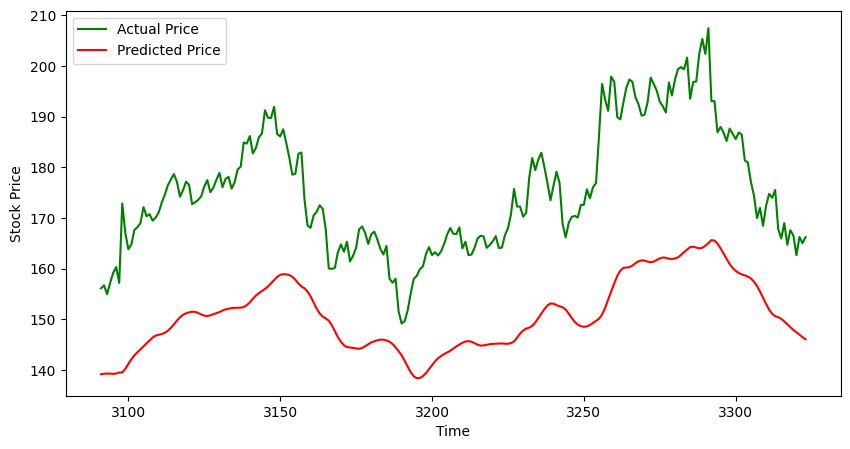

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# 📌 1. Fetch Stock Data
start = '2005-01-01'
end = '2025-03-24'
stock = 'GOOG'
data = yf.download(stock, start, end)

# Reset index and select relevant features
data.reset_index(inplace=True)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# 📌 2. Scale the Data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)  # Scale all features

# 📌 3. Train-Test Split (80% Train, 10% Validation, 10% Test)
train_size = int(len(data) * 0.80)
val_size = int(len(data) * 0.90)

train_data = data_scaled[:train_size]
val_data = data_scaled[train_size:val_size]
test_data = data_scaled[val_size:]

# 📌 4. Create Sequences for LSTM
def create_sequences(data, time_steps=100):
    x, y = [], []
    for i in range(time_steps, len(data)):
        x.append(data[i-time_steps:i])  
        y.append(data[i, 3])  # Predicting the 'Close' price
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_data)
x_val, y_val = create_sequences(val_data)
x_test, y_test = create_sequences(test_data)

# 📌 5. Define a More Advanced LSTM Model
model = Sequential([
    LSTM(units=100, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(units=80, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(units=60, activation='relu', return_sequences=False),
    Dropout(0.3),
    Dense(units=1)
])

# 📌 6. Compile & Train the Model
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), verbose=1)

# 📌 7. Make Predictions
predictions = model.predict(x_test)

# 📌 8. Reverse Scaling for Correct Predictions
predictions_full = np.zeros((len(predictions), data.shape[1]))
predictions_full[:, 3] = predictions[:, 0]  # Put predictions in the Close column
predictions = scaler.inverse_transform(predictions_full)[:, 3]  # Reverse scale only Close price

# 📌 9. Plot Results
actual_prices = data['Close'][val_size:].values[-len(predictions):]  # Match lengths
actual_dates = data.index[val_size:][-len(predictions):]  # Match dates

plt.figure(figsize=(10,5))
plt.plot(actual_dates, actual_prices, label='Actual Price', color='green')
plt.plot(actual_dates, predictions, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 📌 10. Save the Improved Model
model.save('stock_predictions_model.keras')
